In [22]:
#import pairs_backtest as pb
import talib 
import numpy as np
import datetime as dt #in-built module
import pandas as pd
from pandas_datareader import data
import yfinance as yf
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path
import os
from tqdm import tqdm   
from pairs_backtest import kalman_lib as kalman
from pairs_backtest import find_pairs
from pairs_backtest import utils
from pandas_datareader import data as pdr
import statsmodels.tsa.stattools as ts

In [23]:
def get_data(code,start,end):
    data = yf.Ticker(code)
    data = data.history(start = start, end = end)
    #data.index = data.index.strftime('%d/%m/%Y')
    return data

In [24]:
date = dt.datetime.now()
date ='%s_%s_%s'%(date.year,date.month,date.day)
backtest_day = 730
market = 'US'

#end = pd.Timestamp('2023-12-07')
end = dt.date.today()

#start = dt.datetime.now()- dt.timedelta(days=backtest_day)
start = end- dt.timedelta(days=backtest_day)
#end = dt.datetime.now()

#start = pd.Timestamp('2012-01-01')
#end = pd.Timestamp('2023-12-01')
#end = dt.date.today()

if not os.path.exists('for_testing'):
  os.makedirs('for_testing')
first_inst = 'ROL'
second_inst = 'XYL'
combin_df = pd.DataFrame()

x_df = get_data(first_inst,start,end)
y_df = get_data(second_inst,start,end)
common_index = (x_df.index).intersection(y_df.index)
x_df = x_df.loc[common_index].copy()
y_df = y_df.loc[common_index].copy()

result = ts.coint(((x_df['Close'])),(y_df['Close']))
score = result[0]
pvalue = result[1]

print('Score:', score)
print('pvalue:', pvalue)

df, sharpe, _ = kalman.backtest(x_df.Close, y_df.Close) #df1 = x; df2 = y
df = df.dropna()
df.to_csv('for_testing/%s_%s.csv'%(first_inst,second_inst))
print ('%s vs %s has sharp ratio of %0.2f' %(first_inst,second_inst,sharpe))
print (df.tail()[['y','x','hr','numUnits']])

Score: -3.4126073671654287
pvalue: 0.040969350817816046
ROL vs XYL has sharp ratio of 2.02
                                    y          x        hr  numUnits
Date                                                                
2024-01-11 00:00:00-05:00  111.669998  43.849998 -2.528950       1.0
2024-01-12 00:00:00-05:00  111.730003  43.750000 -2.524739       1.0
2024-01-16 00:00:00-05:00  110.959999  43.680000 -2.519820       1.0
2024-01-17 00:00:00-05:00  109.690002  43.369999 -2.514284       1.0
2024-01-18 00:00:00-05:00  111.400002  43.720001 -2.509964       1.0


In [25]:
def py_plot(df1,date,first_instrument,second_instrument):
    if not os.path.exists('py_plot'):
        os.makedirs('py_plot')

    path = 'py_plot'

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize=(14,20))
    df1['X_sell_price'] = df1[df1['numUnits']==1]['x']
    df1['Y_Buy_price'] = df1[df1['numUnits']==1]['y']
    df1['X_Buy_price'] = df1[df1['numUnits']==-1]['x']
    df1['Y_sell_price'] =df1[df1['numUnits']==-1]['y']


    ax1 = df1[['x','y']].plot(ax=ax1)
    ax1.scatter(df1.index , df1['Y_Buy_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax1.scatter(df1.index , df1['X_sell_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax1.scatter(df1.index , df1['X_Buy_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax1.scatter(df1.index , df1['Y_sell_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax2 = df1[['cum rets']].plot(ax = ax2)
    #df['p_value'].plot(ax = ax2)
    df1['zScore']= df1['zScore'].fillna(0)
    ax3= df1['zScore'].plot(ax = ax3)
    ax2.axhline(y = 1, color = 'r', linestyle = 'dashed')
    ax3.axhline(y = 1.5, color = 'r', linestyle = 'dashed')
    ax3.axhline(y = -1.5, color = 'r', linestyle = 'dashed')
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig(path+'/%s vs %s_%s.jpeg'%(first_instrument,second_instrument,date))
    #plt.close('all')
    return ax1,ax2,ax3

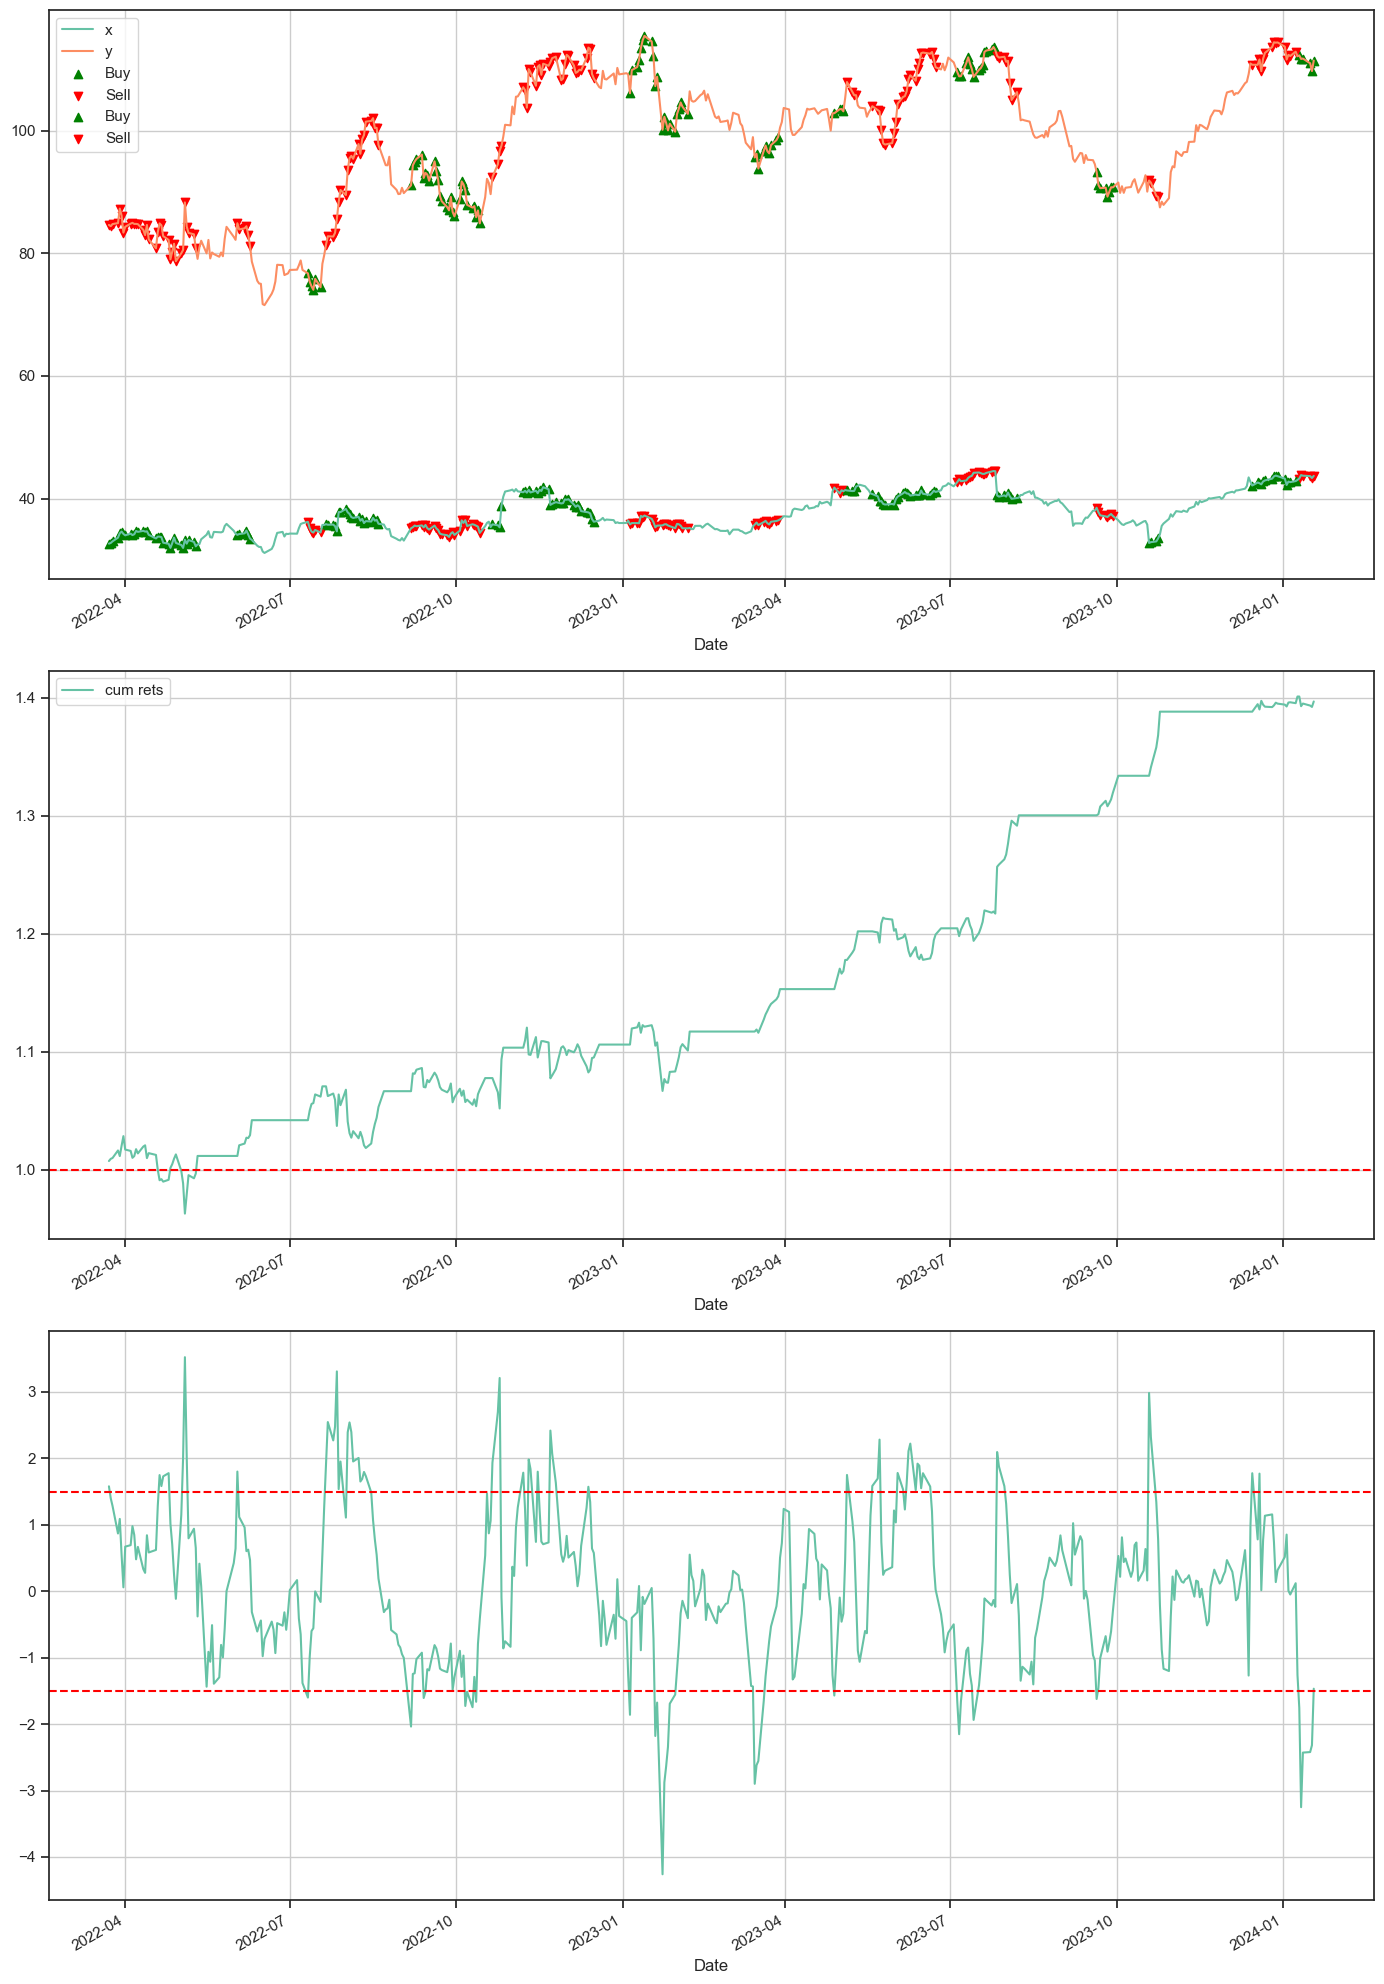

In [29]:
axes_tuple = py_plot(df,date,first_inst,second_inst)
# Plot the axes directly
#fig, axs = plt.subplots(3, 1)  # Create a figure with 3 subplots
#axs[0] = axes_tuple[0].plot()
#axs[1] = axes_tuple[1].plot()
#axs[2] = axes_tuple[2].plot()

# Display the plots
#plt.tight_layout()  # Adjust the spacing between subplots
#plt.show()


In [27]:
plt.close()

In [28]:
df.tail()

,y,x,hr,spread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets,X_sell_price,Y_Buy_price,X_Buy_price,Y_sell_price
Date,,,,,,,,,,,,,,,,,,,
2024-01-11 00:00:00-05:00,111.669998,43.849998,-2.528950,0.775549,-3.251,False,False,1.0,False,False,0.0,1.0,-0.008195,-0.008195,1.392732,43.849998,111.669998,NaN,NaN
2024-01-12 00:00:00-05:00,111.730003,43.750000,-2.524739,1.272655,-2.429,False,False,1.0,False,False,0.0,1.0,0.002237,0.002237,1.394969,43.750000,111.730003,NaN,NaN
2024-01-16 00:00:00-05:00,110.959999,43.680000,-2.519820,0.894275,-2.421,False,False,1.0,False,False,0.0,1.0,-0.001712,-0.001712,1.393257,43.680000,110.959999,NaN,NaN
2024-01-17 00:00:00-05:00,109.690002,43.369999,-2.514284,0.645495,-2.318,False,False,1.0,False,False,0.0,1.0,-0.001137,-0.001137,1.392120,43.369999,109.690002,NaN,NaN
2024-01-18 00:00:00-05:00,111.400002,43.720001,-2.509964,1.664393,-1.467,False,False,1.0,False,False,0.0,1.0,0.004608,0.004608,1.396727,43.720001,111.400002,NaN,NaN
